# Options Project

*By Daniel Deutsch and José Lucas Barretto*

In [70]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy import stats
from matplotlib import pyplot as plt

In [71]:
plt.style.use('ggplot')
plt.rcParams.update({
    'figure.figsize': (15, 4),
    'axes.prop_cycle': plt.cycler(color=["#4C72B0", "#C44E52", "#55A868", "#8172B2", "#CCB974", "#64B5CD"]),
    'axes.facecolor': "#EAEAF2"
})

# Pricing Models

In [75]:
def BOPM(S, X, sigma, r, T, N, type_='call'):
    """_summary_

    Args:
        S (_type_): Market price of the underlying at initial date
        X (_type_): Strike price of the underlying at maturity T
        sigma (_type_): annualized volatility of the underlying asset's returns
        r (_type_): risk free rate
        T (_type_): Maturity
        N (_type_): Number of timesteps
        type_ (str, optional): Type of the option (either 'call' or 'put'). Defaults to 'call'.

    Returns:
        _type_: _description_
    """
    
    # Calculates variables
    dt = T/N
    u = np.exp( sigma * np.sqrt(dt) )
    d =  np.exp( -sigma * np.sqrt(dt) )
    pi_u = ( np.exp(r*dt) - d) / (u - d)

    # Instantiates arrays
    stock_price = np.zeros((N+1, N+1))
    intrinsic_value = np.zeros((N+1, N+1))
    option_price = np.zeros((N+1, N+1))

    # Fills the intrinsic value and stock arrays
    # Note that some of the indexes are different because python's arrays starts with 0 instead of 1.
    for i in range(N+1):
        for j in range(i+1):
            stock_price[i, j] = S * u**j * d**(i-j)
            if type_ == 'call':
                intrinsic_value[i, j] = max(stock_price[i, j] - X, 0)
            elif type_ == 'put':
                intrinsic_value[i, j] = max(X - stock_price[i, j], 0)

    # Calculates the option array
    option_price[option_price.shape[0]-1, :] = intrinsic_value[intrinsic_value.shape[0]-1, :]
    for i in list(range(N))[::-1]:
        for j in list(range(i+1)):
            option_price[i, j] = ((1-pi_u)*option_price[i+1, j] + pi_u*option_price[i+1, j+1])/np.exp(r*dt)

    return option_price[0, 0], option_price, stock_price


def plot_tree(option_price):

    n, _ = option_price.shape

    G = nx.Graph()
    for i in range(0, n+1):
        for j in range(1, i+2):
            if i < n:
                G.add_edge( (i, j), (i+1, j) )
                G.add_edge( (i, j), (i+1, j+1) )
    posG = {}
    for node in G.nodes():
        print(node[0], n+2+node[0]-2*node[1])
        posG[node] = ( node[0], n+2+node[0]-2*node[1] )

    nx.draw(G, pos=posG)

    plt.figtext(0.08,0.6,"Stock price=$20")
    plt.figtext(0.75,0.91,"Stock price=$22")
    plt.figtext(0.75,0.87,"Option price=$1")
    plt.figtext(0.75,0.28,"Stock price=$18")
    plt.figtext(0.75,0.24,"Option price=0")
    plt.figtext(0.75,0.24,"Option price=0")
    plt.show()   


0 2
1 3
1 1
2 4
2 2
2 0


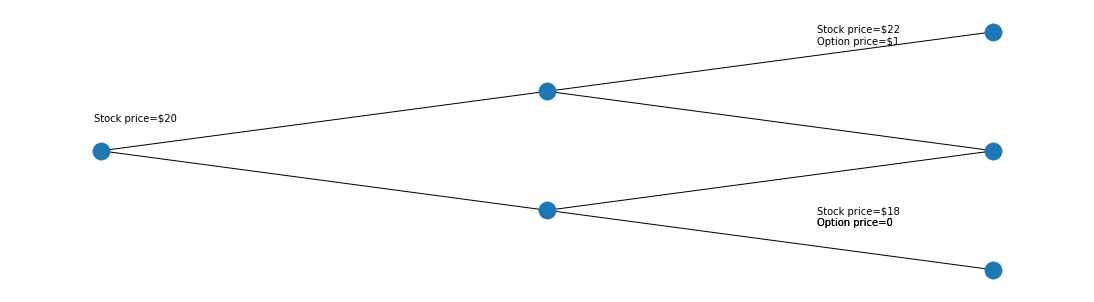

In [79]:
# Global parameters
S = 110
sigma = 0.1
X = 100
r = 0.01
T = 1

price, option_price, __ = BOPM(S, X, sigma, r, T, 1)
plot_tree(option_price)

In [73]:
def BSMOPM(S, X, sigma, r, T, type_='call'):
    
    d1 = (np.log(S/X) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    C = S*stats.norm.cdf(d1) - X*np.exp(-r*T)*stats.norm.cdf(d2)
    P = C - S + (X*np.exp(-r*T))

    return C if type_ == 'call' else P

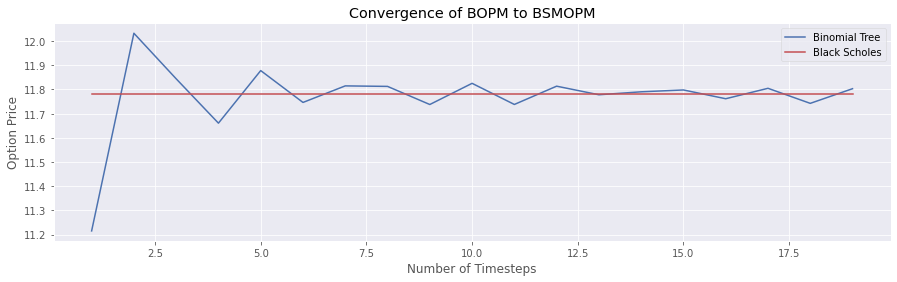

In [58]:
# Global parameters
S = 110
sigma = 0.1
X = 100
r = 0.01
T = 1

binomial_tree, black_scholes = [], []
for N in range(1, 20):

    # Appends binomial tree price
    price, _, __ = BOPM(S, X, sigma, r, T, N)
    binomial_tree.append(price)

    # Appends Black Scholes price
    price = BSMOPM(S, X, sigma, r, T)
    black_scholes.append(price)

# Plot
plt.plot(range(1, 20), binomial_tree, label="Binomial Tree")
plt.plot(range(1, 20), black_scholes, label="Black Scholes")
plt.title("Convergence of BOPM to BSMOPM")
plt.ylabel("Option Price")
plt.xlabel("Number of Timesteps")
plt.legend()
plt.show()